In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "Virny":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /home/denys_herasymuk/UCU/4course_2term/Bachelor_Thesis/Code/Virny


# One Run Multiple Models Interface Usage

In this example, we are going to audit 5 models for stability and fairness, visualize metrics, and create an analysis report. We will use `run_metrics_computation_with_config` interface that will execute the auditing pipeline for all defined models. For that, we will need to do the next steps:

* Initialize input variables

* Compute subgroup metrics

* Make group metrics composition

* Create metrics visualizations and an analysis report

## Import dependencies

In [4]:
import os
import pandas as pd
from datetime import datetime, timezone

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from virny.user_interfaces.metrics_computation_interfaces import run_metrics_computation_with_config
from virny.utils.custom_initializers import create_config_obj, read_model_metric_dfs
from virny.custom_classes.metrics_visualizer import MetricsVisualizer
from virny.custom_classes.metrics_composer import MetricsComposer
from virny.custom_classes.base_dataset import BaseDataset
from virny.configs.constants import ReportType

## Initialize Input Variables

Based on the library flow, we need to create 3 input objects for a user interface:

* A **dataset class** that is a wrapper above the user’s raw dataset that includes its descriptive attributes like a target column, numerical columns, categorical columns, etc. This class must be inherited from the BaseDataset class, which was created for user convenience.

* A **config yaml** that is a file with configuration parameters for different user interfaces for metrics computation.

* Finally, a **models config** that is a Python dictionary, where keys are model names and values are initialized models for analysis. This dictionary helps conduct audits of multiple models for one or multiple runs and analyze different types of models.

### Create a Dataset class

Based on the BaseDataset class, your **dataset class** should include the following attributes:

* **Obligatory attributes**: dataset, target, features, numerical_columns, categorical_columns

* **Optional attributes**: X_data, y_data, columns_with_nulls

For more details, please refer to the library documentation.

In [5]:
import numpy as np
from folktables import ACSDataSource, ACSEmployment


def optimize_data_loading(data, categorical):
    """
    Optimizing the dataset size by downcasting categorical columns
    """
    for column in categorical:
        data[column] = pd.to_numeric(data[column], downcast='integer')
    return data


class ACSEmploymentDataset(BaseDataset):
    def __init__(self, state, year, root_dir=os.path.join(os.getcwd(), 'virny', 'data'),
                 with_nulls=False, optimize=True, subsample=None):
        """
        Loading task data: instead of using the task wrapper, we subsample the acs_data dataframe on the task features
        We do this to retain the nulls as task wrappers handle nulls by imputing as a special category
        Alternatively, we could have altered the configuration from here:
        https://github.com/zykls/folktables/blob/main/folktables/acs.py
        """
        data_source = ACSDataSource(
            survey_year=year,
            horizon='1-Year',
            survey='person',
            root_dir=root_dir
        )
        acs_data = data_source.get_data(states=state, download=True)
        if subsample is not None:
            acs_data = acs_data.sample(subsample)

        dataset = acs_data
        features = ACSEmployment.features
        target = ACSEmployment.target
        categorical_columns = ['MAR', 'MIL', 'ESP', 'MIG', 'DREM', 'NATIVITY', 'DIS', 'DEAR', 'DEYE', 'SEX', 'RAC1P', 'RELP', 'CIT', 'ANC','SCHL']
        numerical_columns = ['AGEP']

        if with_nulls is True:
            X_data = acs_data[features]
        else:
            X_data = acs_data[features].apply(lambda x: np.nan_to_num(x, -1))

        if optimize:
            X_data = optimize_data_loading(X_data, categorical_columns)

        optimized_X_data = X_data[categorical_columns].astype('str')
        for col in numerical_columns:
            optimized_X_data[col] = X_data[col]
        y_data = acs_data[target].apply(lambda x: int(x == 1))

        columns_with_nulls = optimized_X_data.columns[optimized_X_data.isna().any().to_list()].to_list()

        super().__init__(
            pandas_df=dataset,
            features=features,
            target=target,
            numerical_columns=numerical_columns,
            categorical_columns=categorical_columns,
            X_data=optimized_X_data,
            y_data=y_data,
            columns_with_nulls=columns_with_nulls,
        )

In [20]:
dataset = ACSEmploymentDataset(state=['GA'], year=2018, root_dir=os.path.join('virny', 'datasets'), with_nulls=False, subsample=20_000)
dataset.X_data[dataset.X_data.columns[:9]].head()

,MAR,MIL,ESP,MIG,DREM,NATIVITY,DIS,DEAR,DEYE
12327,5,4,0,3,2,1,2,2,2
99831,3,4,0,1,2,2,2,2,2
42838,5,4,0,1,2,1,2,2,2
13915,5,0,5,1,0,1,2,2,2
37946,1,4,0,1,2,2,2,2,2


### Create a config object

`run_metrics_computation_with_config` interface requires that your **yaml file** includes the following parameters:

* **dataset_name**: a name of your dataset; it will be used to name files with metrics.

* **test_set_fraction**: the fraction from the whole dataset in the range [0.0 - 1.0] to create a test set.

* **bootstrap_fraction**: the fraction from a train set in the range [0.0 - 1.0] to fit models in bootstrap (usually more than 0.5).

* **n_estimators**: the number of estimators for bootstrap to compute subgroup variance metrics.

* **sensitive_attributes_dct**: a dictionary where keys are sensitive attribute names (including attribute intersections), and values are privileged values for these attributes. Currently, the library supports only intersections among two sensitive attributes. Intersectional attributes must include '&' between sensitive attributes. You do not need to specify privileged values for intersectional groups since they will be derived from privileged values in sensitive_attributes_dct for each separate sensitive attribute in this intersectional pair.


In [7]:
ROOT_DIR = os.path.join('docs', 'examples')
config_yaml_path = os.path.join(ROOT_DIR, 'experiment_compas_config.yaml')
config_yaml_content = \
"""
dataset_name: Folktables_GA_2018
test_set_fraction: 0.2
bootstrap_fraction: 0.8
n_estimators: 20  # Better to input the higher number of estimators than 100; this is only for this use case example
sensitive_attributes_dct: {'SEX': '1', 'RAC1P': '1', 'SEX&RAC1P': None}
"""

with open(config_yaml_path, 'w', encoding='utf-8') as f:
    f.write(config_yaml_content)

In [8]:
config = create_config_obj(config_yaml_path=config_yaml_path)
SAVE_RESULTS_DIR_PATH = os.path.join(ROOT_DIR, 'results',
                                     f'{config.dataset_name}_Metrics_{datetime.now(timezone.utc).strftime("%Y%m%d__%H%M%S")}')

### Create a models config

**models_config** is a Python dictionary, where keys are model names and values are initialized models for analysis

In [9]:
models_config = {
    'DecisionTreeClassifier': DecisionTreeClassifier(criterion='gini',
                                                     max_depth=10,
                                                     max_features=0.6,
                                                     min_samples_split=0.1),
    'LogisticRegression': LogisticRegression(C=1,
                                             max_iter=150,
                                             penalty='l2',
                                             solver='lbfgs'),
    'KNeighborsClassifier': KNeighborsClassifier(metric='minkowski',
                                                 n_neighbors=25,
                                                 weights='uniform'),
    'RandomForestClassifier': RandomForestClassifier(max_depth=10,
                                                     max_features=0.6,
                                                     min_samples_leaf=4,
                                                     n_estimators=100),
    'XGBClassifier': XGBClassifier(reg_lambda=1,
                                   learning_rate=0.1,
                                   max_depth=3,
                                   n_estimators=100),
}

## Subgroup Metrics Computation

After the variables are input to a user interface, the interface creates a **generic pipeline** based on the input dataset class to hide preprocessing complexity and provide handy attributes and methods for different types of model analysis. Later this generic pipeline is used in subgroup analyzers that compute different sets of metrics. As for now, our library supports **Subgroup Variance Analyzer** and **Subgroup Statistical Bias Analyzer**, but it is easily extensible to any other analyzers. When the variance and bias analyzers complete metrics computation, their metrics are combined, returned in a matrix format, and stored in a file if defined.

In [10]:
subgroup_metrics_dct = run_metrics_computation_with_config(dataset, config, models_config, SAVE_RESULTS_DIR_PATH, run_seed=100)

Analyze models in one run:   0%|          | 0/5 [00:00<?, ?it/s]

##############################  [Model 1 / 5] Analyze DecisionTreeClassifier  ##############################
Model random_state:  101
Baseline X_train shape:  (16000, 16)
Baseline X_test shape:  (4000, 16)




2023-02-05 18:50:46 abstract_overall_variance_analyzer.py INFO    : Start classifiers testing by bootstrap


Classifiers testing by bootstrap:   0%|          | 0/20 [00:00<?, ?it/s]

2023-02-05 18:50:47 abstract_overall_variance_analyzer.py INFO    : Successfully tested classifiers by bootstrap
2023-02-05 18:50:49 abstract_overall_variance_analyzer.py INFO    : Successfully computed predict proba metrics






##############################  [Model 2 / 5] Analyze LogisticRegression  ##############################
Model random_state:  102
Baseline X_train shape:  (16000, 16)
Baseline X_test shape:  (4000, 16)




2023-02-05 18:50:56 abstract_overall_variance_analyzer.py INFO    : Start classifiers testing by bootstrap


Classifiers testing by bootstrap:   0%|          | 0/20 [00:00<?, ?it/s]

2023-02-05 18:51:14 abstract_overall_variance_analyzer.py INFO    : Successfully tested classifiers by bootstrap
2023-02-05 18:51:15 abstract_overall_variance_analyzer.py INFO    : Successfully computed predict proba metrics






##############################  [Model 3 / 5] Analyze KNeighborsClassifier  ##############################
Model random_state:  None
Baseline X_train shape:  (16000, 16)
Baseline X_test shape:  (4000, 16)




2023-02-05 18:51:18 abstract_overall_variance_analyzer.py INFO    : Start classifiers testing by bootstrap


Classifiers testing by bootstrap:   0%|          | 0/20 [00:00<?, ?it/s]

2023-02-05 18:51:26 abstract_overall_variance_analyzer.py INFO    : Successfully tested classifiers by bootstrap
2023-02-05 18:51:27 abstract_overall_variance_analyzer.py INFO    : Successfully computed predict proba metrics






##############################  [Model 4 / 5] Analyze RandomForestClassifier  ##############################
Model random_state:  104
Baseline X_train shape:  (16000, 16)
Baseline X_test shape:  (4000, 16)




2023-02-05 18:51:31 abstract_overall_variance_analyzer.py INFO    : Start classifiers testing by bootstrap


Classifiers testing by bootstrap:   0%|          | 0/20 [00:00<?, ?it/s]

2023-02-05 18:52:05 abstract_overall_variance_analyzer.py INFO    : Successfully tested classifiers by bootstrap
2023-02-05 18:52:06 abstract_overall_variance_analyzer.py INFO    : Successfully computed predict proba metrics






##############################  [Model 5 / 5] Analyze XGBClassifier  ##############################
Model random_state:  105
Baseline X_train shape:  (16000, 16)
Baseline X_test shape:  (4000, 16)




2023-02-05 18:52:08 abstract_overall_variance_analyzer.py INFO    : Start classifiers testing by bootstrap


Classifiers testing by bootstrap:   0%|          | 0/20 [00:00<?, ?it/s]

2023-02-05 18:52:32 abstract_overall_variance_analyzer.py INFO    : Successfully tested classifiers by bootstrap
2023-02-05 18:52:33 abstract_overall_variance_analyzer.py INFO    : Successfully computed predict proba metrics


Look at several columns in top rows of computed metrics

In [11]:
sample_model_metrics_df = subgroup_metrics_dct[list(models_config.keys())[0]]
sample_model_metrics_df[sample_model_metrics_df.columns[:6]].head(20)

,Metric,overall,SEX_priv,SEX_dis,RAC1P_priv,RAC1P_dis
0,Mean,0.553023,0.528359,0.576554,0.542431,0.573288
1,Std,0.052534,0.053111,0.051984,0.052990,0.051662
2,IQR,0.059290,0.058500,0.060044,0.059339,0.059197
3,Entropy,0.000000,0.000000,0.000000,0.000000,0.000000
4,Jitter,0.039426,0.036432,0.042283,0.037529,0.043056
5,Per_Sample_Accuracy,0.813500,0.850563,0.778139,0.810316,0.819592
6,Label_Stability,0.945100,0.948643,0.941720,0.948306,0.938966
7,TPR,0.858539,0.866375,0.849879,0.852694,0.871143
8,TNR,0.792127,0.854808,0.738739,0.787352,0.800487
9,PPV,0.760571,0.839703,0.687561,0.768006,0.745342


## Group Metrics Composition

**Metrics Composer** is responsible for this second stage of the model audit. Currently, it computes our custom group statistical bias and variance metrics, but extending it for new group metrics is very simple. We noticed that more and more group metrics have appeared during the last decade, but most of them are based on the same subgroup metrics. Hence, such a separation of subgroup and group metrics computation allows one to experiment with different combinations of subgroup metrics and avoid subgroup metrics recomputation for a new set of grouped metrics.

In [12]:
models_metrics_dct = read_model_metric_dfs(SAVE_RESULTS_DIR_PATH, model_names=list(models_config.keys()))

In [13]:
metrics_composer = MetricsComposer(models_metrics_dct, config.sensitive_attributes_dct)

Compute composed metrics

In [14]:
models_composed_metrics_df = metrics_composer.compose_metrics()

## Metrics Visualization and Reporting

**Metrics Visualizer** provides metrics visualization and reporting functionality. It unifies different preprocessing methods for result metrics and creates various data formats required for visualizations. Hence, users can simply call methods of the Metrics Visualizer class and get custom plots for diverse metrics analysis. Additionally, these plots could be collected in an HTML report with comments for user convenience and future reference.

In [15]:
visualizer = MetricsVisualizer(models_metrics_dct, models_composed_metrics_df, config.dataset_name,
                               model_names=list(models_config.keys()),
                               sensitive_attributes_dct=config.sensitive_attributes_dct)

In [16]:
visualizer.create_overall_metrics_bar_char(
    metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate', 'Positive-Rate'],
    metrics_title="Bias Metrics"
)

alt.Chart(...)

In [17]:
visualizer.create_overall_metrics_bar_char(
    metrics_names=['Label_Stability'],
    reversed_metrics_names=['Std', 'IQR', 'Jitter'],
    metrics_title="Variance Metrics"
)

alt.Chart(...)

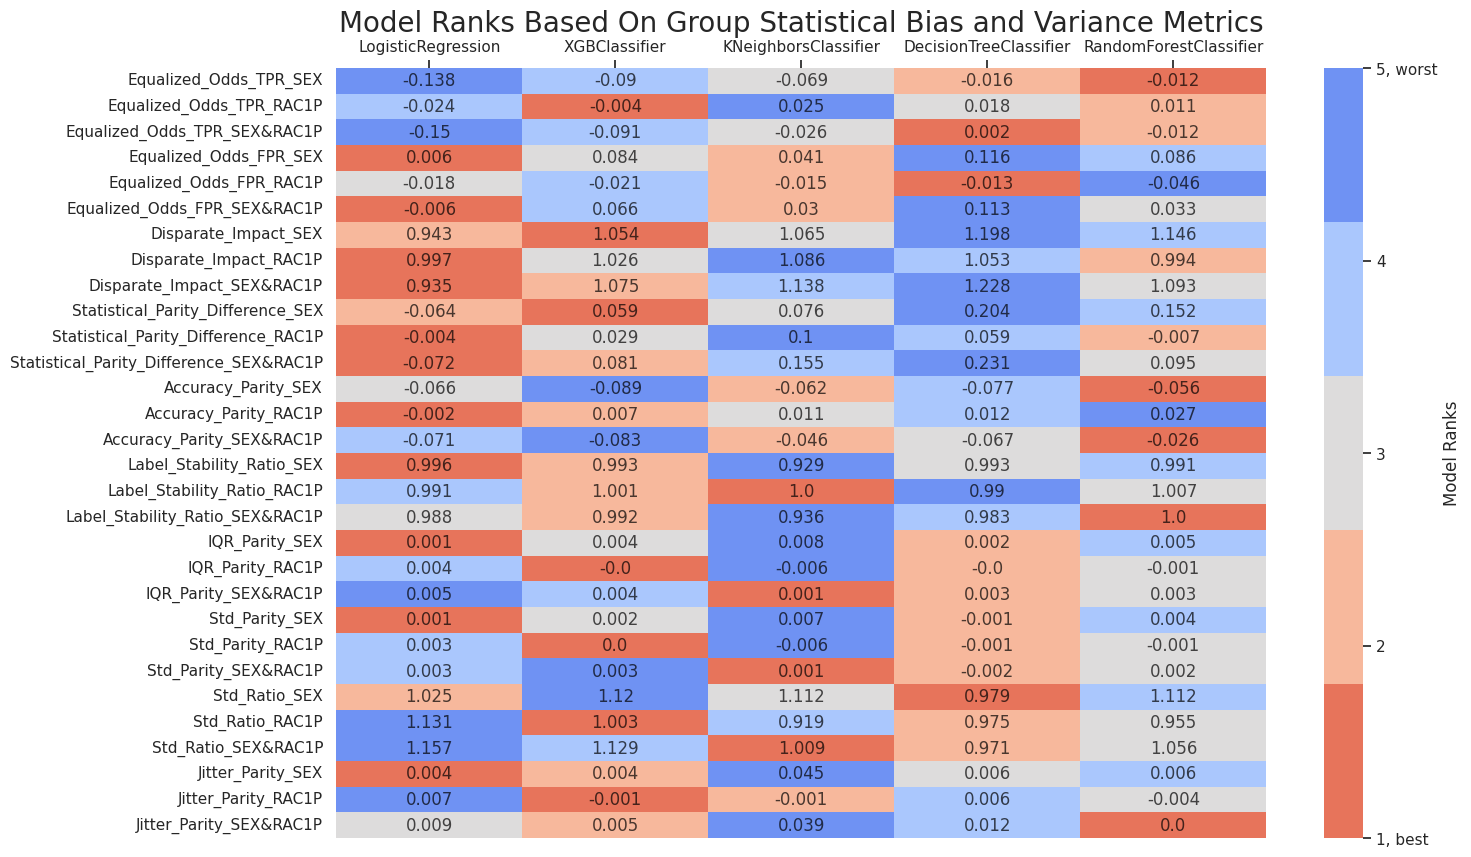

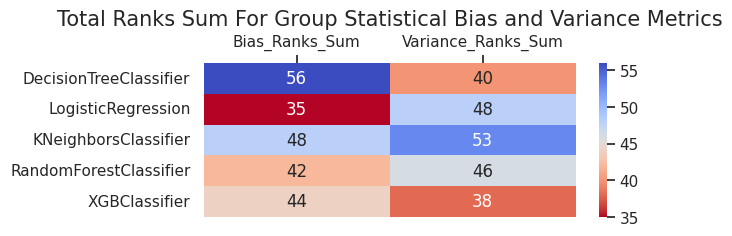

In [18]:
visualizer.create_model_rank_heatmaps(
    metrics_lst=[
        # Group statistical bias metrics
        'Equalized_Odds_TPR',
        'Equalized_Odds_FPR',
        'Disparate_Impact',
        'Statistical_Parity_Difference',
        'Accuracy_Parity',
        # Group variance metrics
        'Label_Stability_Ratio',
        'IQR_Parity',
        'Std_Parity',
        'Std_Ratio',
        'Jitter_Parity',
    ],
    groups_lst=config.sensitive_attributes_dct.keys(),
)

Create an analysis report. It includes correspondent visualizations and details about your result metrics.

In [19]:
visualizer.create_html_report(report_type=ReportType.ONE_RUN_MULTIPLE_MODELS,
                              report_save_path=os.path.join(ROOT_DIR, "results", "reports"))

App saved to ./docs/examples/results/reports/Folktables_GA_2018_Metrics_Report_20230205__165240.html